In [1]:
from chromatic_fitting import *

Running chromatic_fitting v0.11.0!

This program is running on:
Python v3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy v1.21.6
chromatic v0.4.5
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


In [2]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pymc3 as pm
# import pymc3_ext as pmx
# import exoplanet as xo
# import os
# import starry
# from corner import corner
import corner

# np.random.seed(12)
starry.config.lazy = True
starry.config.quiet = True

In [3]:
# import theano
# theano.config.gcc__cxxflags += " -fexceptions"

In [4]:
hatp18b = Rainbow("/Users/catrionamurray/Documents/Postdoc/CUBoulder/JWST_data/*/*/jw02734-o001_t001_niriss_clear-gr700xd-substrip256/*.fits")

🌈🤖 This file contains data for 3 spectrosopic orders. Because no
`order=` keyword was supplied, we're defaulting to first order. You can
hide this warning by expliciting stating which order you want to load.
For this file, the options include [1 2 3].



  0%|          | 0/469 [00:00<?, ?it/s]

🌈🤖 The 2048 input wavelengths were not monotonically increasing.
<🌈(2048w, 469t)> has been sorted from lowest to highest wavelength.
If you want to recover the original wavelength order, the original
wavelength indices are available in `rainbow.original_wave_index`.



🌈🤖 The wavelength scale for this rainbow is '?',
and there are 2048 wavelength centers and
2048 wavelength edges defined.

It's hard to imshow something with a wavelength axis
that isn't linearly or logarithmically uniform, or doesn't
at least have its wavelength edges defined. We're giving up
and just using the wavelength index as the wavelength axis.

If you want a real wavelength axis, one solution would
be to bin your wavelengths to a more uniform grid with
`rainbow.bin(R=...)` (for logarithmic wavelengths) or
`rainbow.bin(dw=...)` (for linear wavelengths)



<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='Wavelength Index'>

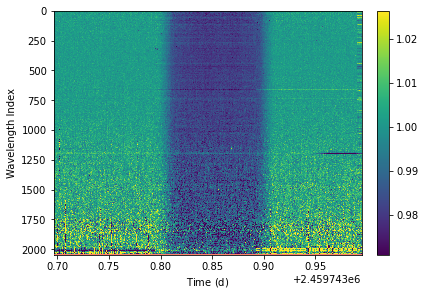

In [5]:
hatp18b = hatp18b.normalize()
hatp18b.imshow()

  0%|          | 0/469 [00:00<?, ?it/s]

<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='log$_{10}$[Wavelength/($\\mathrm{\\mu m}$)]'>

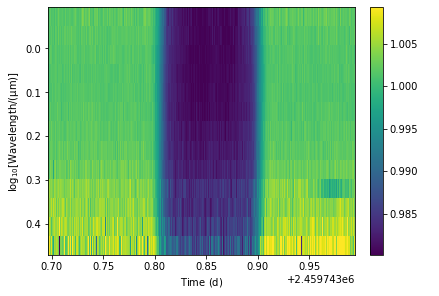

In [6]:
bin_hatp18b = hatp18b.bin(R=10)
bin_hatp18b.imshow()

  0%|          | 0/469 [00:00<?, ?it/s]

<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='Wavelength ($\\mathrm{\\mu m}$)'>

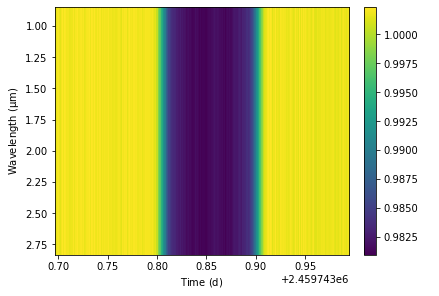

In [7]:
wlc_hatp18b = hatp18b.bin(nwavelengths=hatp18b.nwave)
wlc_hatp18b.imshow()

In [8]:
# wlc_hatp18b.flux[:,242:272] = np.nan

In [9]:
# wlc_hatp18b.flux[:,242:272]

In [10]:
# wlc_hatp18b.timelike['ok'] = np.array([True] * wlc_hatp18b.ntime)
# wlc_hatp18b.timelike['ok'][242:272] = False

  0%|          | 0/1 [00:00<?, ?it/s]

<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='Relative Flux (+ offsets)'>

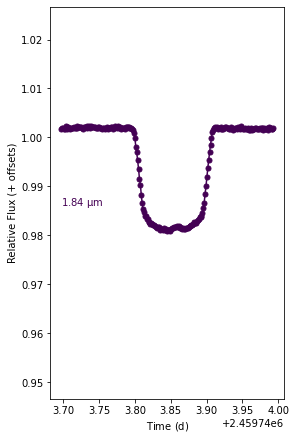

In [11]:
wlc_hatp18b.bin(ntimes=2).trim().plot()

In [21]:
np.nanmedian(wlc_hatp18b.uncertainty)

<Quantity 5.28527773e-05>

In [12]:
# star_temp = 4800 * u.K
# logg = 4.58765 
# metallicity = 0.0
# distance = 161 * u.pc
# radius = 0.7305 * u.Rsun

# spot_temp = 3596 * u.K

# # get the spectrum from the surface
# _, surface_flux = get_phoenix_photons(
#         temperature=u.Quantity(star_temp).value,
#         logg=logg,
#         metallicity=metallicity,
#         wavelength=bin_hatp18b.wavelength,
#     )

# # get the received flux at Earth
# received_flux = surface_flux * (radius / distance).decompose() ** 2

# # get the spectrum from the surface
# _, surface_flux_spot = get_phoenix_photons(
#         temperature=u.Quantity(spot_temp).value,
#         logg=logg,
#         metallicity=metallicity,
#         wavelength=bin_hatp18b.wavelength,
#     )

# # get the received flux at Earth
# received_flux_spot = surface_flux_spot * (radius / distance).decompose() ** 2

In [13]:
# plt.plot(bin_hatp18b.wavelength, received_flux, label=f'T={star_temp}')
# plt.plot(bin_hatp18b.wavelength, received_flux_spot, label=f'T={spot_temp}')
# plt.ylabel("Received Flux")
# plt.xlabel(f"Wavelength [{hatp18b.wavelength.unit}]")
# plt.legend()

In [14]:
# contrast = 1 - (received_flux_spot/received_flux)
# plt.plot(bin_hatp18b.wavelength,contrast)

In [15]:
t= wlc_hatp18b.time.to_value('d')
flux = wlc_hatp18b.flux[0]
sigma = wlc_hatp18b.uncertainty[0]

In [9]:
# map = starry.Map(ydeg=5)
# map.add_spot(amp=-0.075, sigma=0.1, lat=0, lon=-30)
# A_y = np.array(map.y[1:])

hatp18_params = dict(
    ydeg=20,  # degree of the map
    udeg=2,  # degree of the limb darkening
    inc=88.8,  # inclination in degrees
    amp=1.0,  # amplitude (a value prop. to luminosity)
    r=0.74,  #  radius in R_sun
    m=0.773,  # mass in M_sun
    prot=14.66,  # rotational period in days
    u=[0.10, 0.1],  # limb darkening coefficients
#     y=A_y,  # the spherical harmonic coefficients
)


In [38]:
with pm.Model() as model1:

    # Primary
    star_theory = starry.Primary(
        starry.Map(ydeg=hatp18_params["ydeg"], udeg=hatp18_params["udeg"], amp=hatp18_params['amp'], inc=90),
        r=hatp18_params["r"],
        m=hatp18_params["m"],
        prot=hatp18_params["prot"],
#         inc=30,
        length_unit=u.R_sun,
        mass_unit=u.M_sun,
    )
    star_theory.map[1:] = hatp18_params["u"]
    
    star_theory.map.spot(contrast=1, radius=10, lat=-10, lon=-10)
    
    planet = starry.kepler.Secondary(
    starry.Map(ydeg=5, amp=5e-3),  # the surface map
    m=62.610,  # mass in solar masses
    r=11.153,# radius
    inc=hatp18_params["inc"],
    length_unit=u.R_earth,
    mass_unit=u.M_earth,
    porb=5.508023,  # orbital period in days
    prot=5.508023,  # rotation period in days (synchronous)
    omega=120,  # longitude of ascending node in degrees
    ecc=0.084,  # eccentricity
#     w=120,  # longitude of pericenter in degrees
    t0=2459743.85,  # time of transit in days
    )

    # System
    sys = starry.System(star_theory, planet)

In [39]:
sys.show(t)
# star.map.show(theta=np.linspace(0, 360, 50))

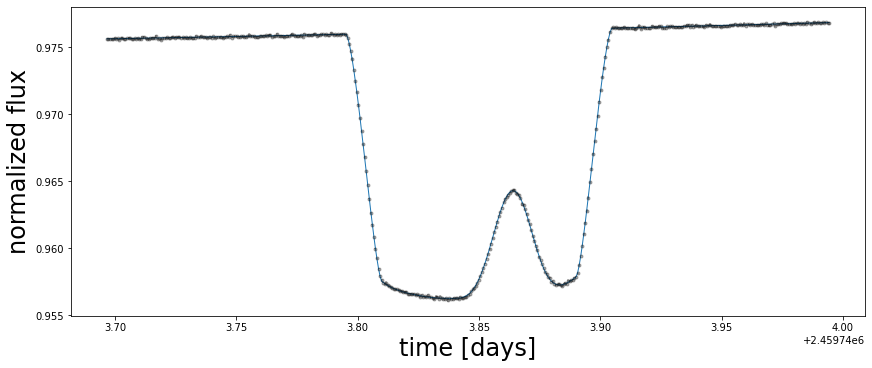

In [41]:
# t = np.linspace(-2.5, 2.5, 1000)
flux_true = eval_in_model(sys.flux(t), model=model1)
# flux_true = flux_true/np.nanmedian(flux_true)
# flux_true = eval_in_model(star.map.flux(theta=360*bin_hatp18b.time.to_value('d')/A["prot"]), model=model)
sigma = 5e-5
ferr = sigma * np.random.randn(len(t))
flux = flux_true + ferr

fig, ax = plt.subplots(1, figsize=(12, 5))
# ax.plot(t, flux, "k.", alpha=0.3, ms=2)
plt.errorbar(t, flux, np.abs(ferr), c="k", fmt='.', alpha=0.3)
ax.plot(t, flux_true, lw=1)
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24);

🌈🤖 The wavelength scale for this rainbow is 'linear',
and there are 1 wavelength centers and
0 wavelength edges defined.

It's hard to imshow something with a wavelength axis
that isn't linearly or logarithmically uniform, or doesn't
at least have its wavelength edges defined. We're giving up
and just using the wavelength index as the wavelength axis.

If you want a real wavelength axis, one solution would
be to bin your wavelengths to a more uniform grid with
`rainbow.bin(R=...)` (for logarithmic wavelengths) or
`rainbow.bin(dw=...)` (for linear wavelengths)



<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='Wavelength Index'>

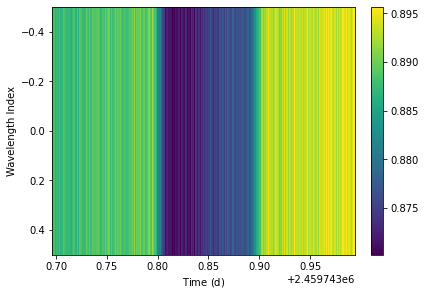

In [19]:
r = SimulatedRainbow(time=t*u.day, wavelength=wlc_hatp18b.wavelength)
r.flux[:] = r.flux * flux
r.uncertainty[:] = np.abs(ferr)
r.imshow()

In [45]:
s.summary

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
transitspot_A[0],9.969499e-01,0.000003,9.969470e-01,9.969535e-01,1.000000e-07,1.000000e-07,678.859701,542.946810,1.004874
transitspot_u[0],2.514258e-01,0.001221,2.504096e-01,2.527042e-01,6.650000e-05,4.710000e-05,265.011660,445.796785,1.016360
transitspot_u[1],2.977001e-01,0.104267,2.119033e-01,4.110391e-01,3.513300e-03,2.485100e-03,882.804225,466.509088,1.007162
transitspot_mp[0],6.266601e+01,0.996571,6.162704e+01,6.364265e+01,4.883140e-02,3.460330e-02,415.545951,515.828994,0.999509
transitspot_rp[0],1.102560e+01,0.002489,1.102337e+01,1.102794e+01,1.126000e-04,7.960000e-05,477.070856,500.374179,1.007000
transitspot_omega[0],1.561590e+02,0.227423,1.559548e+02,1.563881e+02,1.153120e-02,8.161100e-03,379.105814,392.150320,1.009693
data_missing[0],9.810096e-01,0.000036,9.809743e-01,9.810420e-01,1.300000e-06,9.000000e-07,734.034415,403.255220,1.006276
data_missing[1],9.810033e-01,0.000038,9.809671e-01,9.810392e-01,1.300000e-06,9.000000e-07,860.568476,489.991917,1.004547
data_missing[2],9.810030e-01,0.000041,9.809582e-01,9.810416e-01,1.600000e-06,1.100000e-06,654.960208,480.307594,1.004830
data_missing[3],9.810058e-01,0.000038,9.809753e-01,9.810510e-01,1.300000e-06,1.000000e-06,793.906749,548.911789,1.003392


In [23]:
s = TransitSpotModel()
s.setup_parameters(
    A = Fitted(Normal, mu=1.02, sigma=0.01),
    
    # stellar parameters
    rs=hatp18_params["r"], # stellar radius in Sun radius
    ms=hatp18_params["m"], # stellar mass in Sun masses
    prot=hatp18_params["prot"], # stellar rotation period
    u=[0.2514258,0.2977001],#Fitted(Normal, mu=[0.3,0.3], sigma=0.1, shape=2),#hatp18_params["u"], # limb-darkening coeffs
    stellar_inc = 90,#Fitted(Uniform, lower=0, upper=180, testval=90),
    
    # spot parameters
    spot_contrast = Fitted(Uniform,lower=0.0, upper=1.0, testval=0.5),
    spot_radius = Fitted(Uniform,lower=0.0, upper=50, testval=10.0),
    spot_latitude = Fitted(Uniform, lower=-20.0, upper=20, testval=-10),
    spot_longitude = Fitted(Uniform, lower=-70.0, upper=0, testval=-10),
    
    # planet parameters
    mp=Fitted(Normal, mu=62.66601, sigma=1), # planet mass in Earth masses
    rp=Fitted(Normal, mu=11.02560, sigma=0.002489),#mu=11.153, sigma=0.5), # planet radius in Earth radii
    inc=hatp18_params["inc"],
    period=5.508023,  # orbital period in days
    omega=Fitted(Normal, mu=156.1590, sigma=0.227423),  # longitude of ascending node in degrees
    ecc=0.084,  # eccentricity
    t0=Fitted(Normal, mu=2459743.8533670832, sigma=6.6778e-06)
#     t0=Fitted(Normal,mu=2459743.85, sigma=0.005),  # time of transit in days
#     amp=Fitted(Uniform, lower=0, upper=1, testval=5e-3)
)

In [24]:
s.summarize_parameters()

transitspot_A =
  <🧮 Fitted Normal(mu=1.02, sigma=0.01, name='transitspot_A') 🧮>

transitspot_rs =
  <🧮 Fixed | 0.74 🧮>

transitspot_ms =
  <🧮 Fixed | 0.773 🧮>

transitspot_stellar_amp =
  <🧮 Fixed | 1 🧮>

transitspot_stellar_inc =
  <🧮 Fixed | 90 🧮>

transitspot_prot =
  <🧮 Fixed | 14.66 🧮>

transitspot_u =
  <🧮 Fixed | [0.2514258, 0.2977001] 🧮>

transitspot_spot_contrast =
  <🧮 Fitted Uniform(lower=0.0, upper=1.0, testval=0.5, name='transitspot_spot_contrast') 🧮>

transitspot_spot_radius =
  <🧮 Fitted Uniform(lower=0.0, upper=50, testval=10.0, name='transitspot_spot_radius') 🧮>

transitspot_spot_latitude =
  <🧮 Fitted Uniform(lower=-20.0, upper=20, testval=-10, name='transitspot_spot_latitude') 🧮>

transitspot_spot_longitude =
  <🧮 Fitted Uniform(lower=-70.0, upper=0, testval=-10, name='transitspot_spot_longitude') 🧮>

transitspot_mp =
  <🧮 Fitted Normal(mu=62.66601, sigma=1, name='transitspot_mp') 🧮>

transitspot_rp =
  <🧮 Fitted Normal(mu=11.0256, sigma=0.002489, name='transitspot_

In [25]:
s.attach_data(wlc_hatp18b.bin(ntimes=2))

  0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
s.setup_lightcurves()

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0


In [27]:
# mask_spot = np.array([False] * s.data.ntime)
# mask_spot[121:136] = True
s.setup_likelihood()#inflate_uncertainties=True)#, mask_outliers=True, data_mask=[mask_spot])

In [28]:
print(s._pymc3_model)

                        transitspot_A ~ Normal
 transitspot_spot_contrast_interval__ ~ TransformedDistribution
   transitspot_spot_radius_interval__ ~ TransformedDistribution
 transitspot_spot_latitude_interval__ ~ TransformedDistribution
transitspot_spot_longitude_interval__ ~ TransformedDistribution
                       transitspot_mp ~ Normal
                       transitspot_rp ~ Normal
                    transitspot_omega ~ Normal
                       transitspot_t0 ~ Normal
            transitspot_spot_contrast ~ Uniform
              transitspot_spot_radius ~ Uniform
            transitspot_spot_latitude ~ Uniform
           transitspot_spot_longitude ~ Uniform
                                 data ~ Normal


In [29]:
s._pymc3_model.test_point

{'transitspot_A': array([1.02]),
 'transitspot_spot_contrast_interval__': array([0.]),
 'transitspot_spot_radius_interval__': array([-1.38629436]),
 'transitspot_spot_latitude_interval__': array([-1.09861229]),
 'transitspot_spot_longitude_interval__': array([1.79175947]),
 'transitspot_mp': array([62.66601]),
 'transitspot_rp': array([11.0256]),
 'transitspot_omega': array([156.159]),
 'transitspot_t0': array([2459743.85336708])}

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (the

message: Desired error not necessarily achieved due to precision loss.
logp: -4562762.2136343485 -> -648.0195968291396
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (the

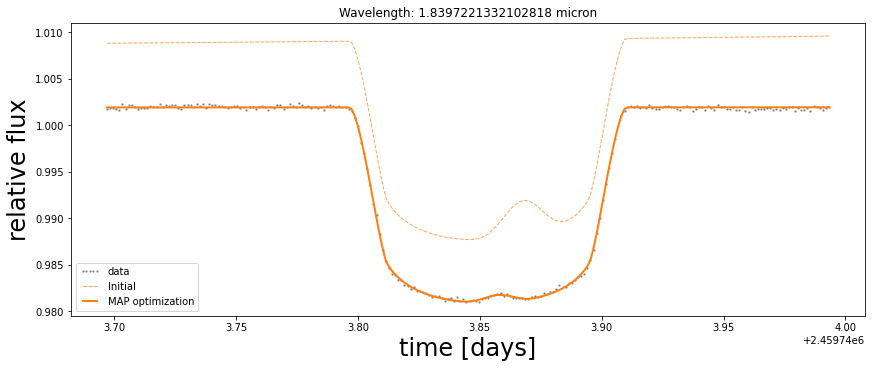

In [30]:
opt = s.optimize(plot=True)

In [31]:
opt

{'transitspot_A': array([0.99805776]),
 'transitspot_spot_contrast_interval__': array([0.31021417]),
 'transitspot_spot_radius_interval__': array([-3.45572614]),
 'transitspot_spot_latitude_interval__': array([-3.60796316]),
 'transitspot_spot_longitude_interval__': array([0.80191232]),
 'transitspot_mp': array([62.61815127]),
 'transitspot_rp': array([11.00504813]),
 'transitspot_omega': array([158.28126681]),
 'transitspot_t0': array([2459743.85336824]),
 'transitspot_spot_contrast': array([0.57693754]),
 'transitspot_spot_radius': array([1.52992759]),
 'transitspot_spot_latitude': array([-18.94433576]),
 'transitspot_spot_longitude': array([-21.67316232])}

In [ ]:
s.sample(start=opt,sampling_method=pmx.sample, draws=300, tune=300, chains=2, cores=1)#, return_inferencedata=True) #start=opt, 

Sampling model using the <function sample at 0x7fc89c45a670> method


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (the

In [ ]:
ax = s.plot_lightcurves(text=False)
# ax.set_ylim(0.865, 0.9)

In [ ]:
s.imshow_with_models()#vlimits_data=[0.87, 0.89])

In [ ]:
import arviz as az
with s._pymc3_model:
    az.plot_trace(s.trace)

In [38]:
results = s.get_results()
results.loc['w0']

nsigma                                     1.004819
nsigma_hdi_16%                             1.003958
nsigma_hdi_84%                             1.005872
transitspot_A                               0.99695
transitspot_A_hdi_16%                      0.996947
                                    ...            
transitspot_t0_hdi_84%               2459743.853373
transitspot_u                              0.251426
transitspot_u_hdi_16%                       0.25041
transitspot_u_hdi_84%                      0.252704
wavelength                1.8397221332102818 micron
Name: w0, Length: 61, dtype: object

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/corner/core.py:103: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(


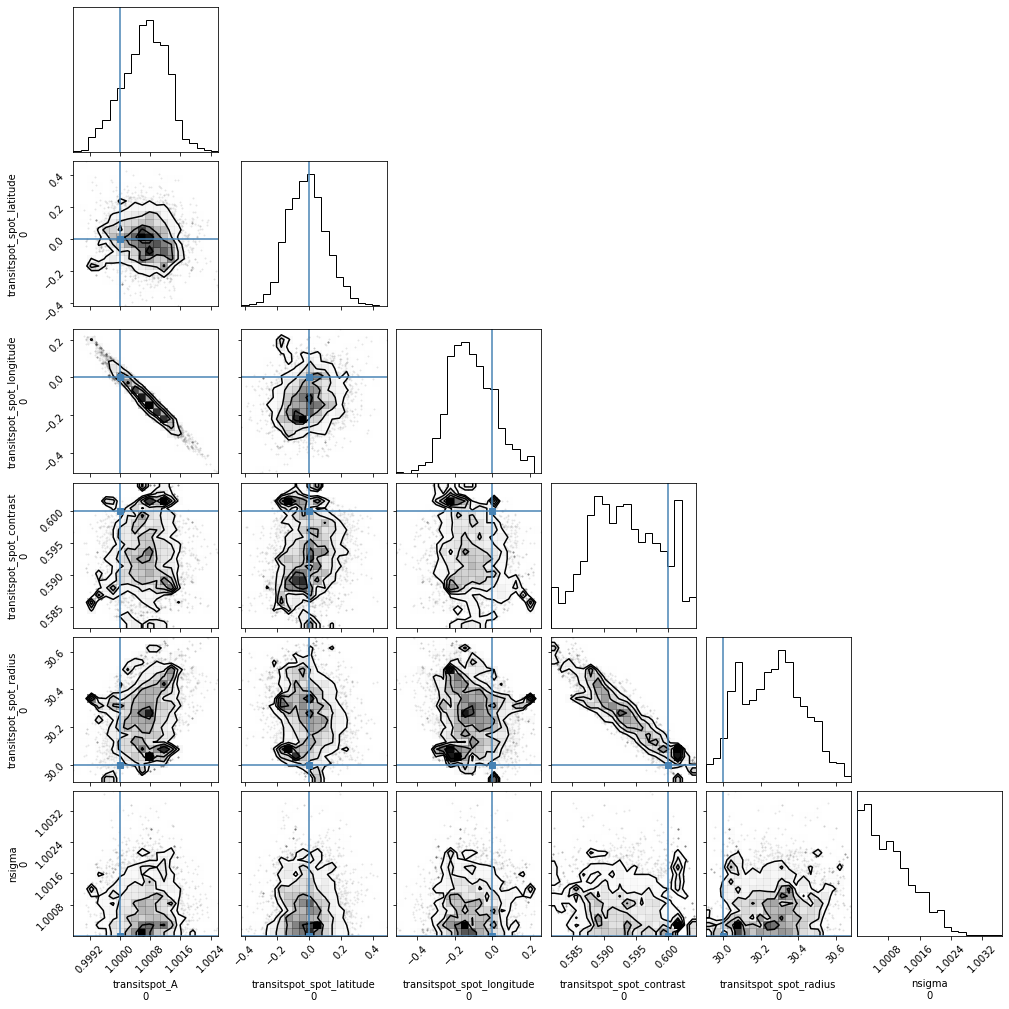

In [41]:
with s._pymc3_model:
    corner.corner(s.trace,
            var_names=[f'{s.name}_A',f'{s.name}_spot_latitude',
                                 f'{s.name}_spot_longitude',
                                 f'{s.name}_spot_contrast',
                                 f'{s.name}_spot_radius',
                                 f'nsigma',],
            truths=[1,0,0,0.6, 30,1])

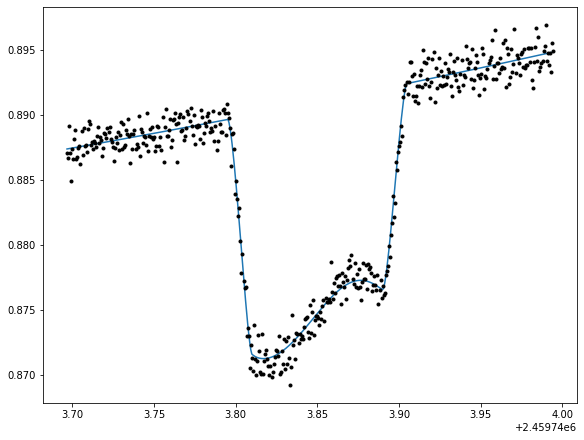

In [36]:
plt.figure(figsize=(8,6))
plt.plot(s.data.time, s._fit_models['w0'])
plt.plot(s.data.time, s.data.flux[0], 'k.')

In [135]:
with pm.Model() as mod:
    
    prot = 1.0

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    contrast = pm.Uniform("contrast",lower=0.0, upper=1.0, testval=0.7)
    spot_radius = pm.Uniform("spot_radius", lower=0.0, upper=180, testval=10.0)
    lat = pm.Normal('lat', mu=0.0, sigma=10)
    lon = pm.Normal('lon', mu=0.0, sigma=10)
    
#     planet_radius = pm.Normal('radius', mu=11.153, sigma=0.583)
#     ecc = pm.TruncatedNormal('ecc', lower=0.0, upper=1.0, mu=0.084, sigma=0.048)
#     ld = pm.Uniform('ld', testval=[0.1,0.1], lower=[0.0,0.0], upper=[1.0,1.0], shape=2)
#     t_transit = pm.Uniform('transit_epoch', lower=2459743.8, upper=2459743.9, testval=2459743.85)
#     omega = pm.Normal('omega', mu=100, sigma=20)
    
    A = pm.Normal('A', mu=1, sigma=0.2)

    star = starry.Primary(
        starry.Map(ydeg=hatp18_params["ydeg"], udeg=hatp18_params["udeg"], amp=hatp18_params["amp"]),
        r=hatp18_params["r"],
        m=hatp18_params["m"],
        prot=hatp18_params["prot"],
        length_unit=u.R_sun,
        mass_unit=u.M_sun,
    )
    star.map[1:] = hatp18_params["u"]
    
    star.map.spot(contrast=contrast, radius=spot_radius, lat=lat, lon=lon)
    
    planet = starry.kepler.Secondary(
        starry.Map(ydeg=5, amp=5e-3),  # the surface map
        m=62.610,  # mass in solar masses
        r=11.153,# radius
        inc=hatp18_params["inc"],
        length_unit=u.R_earth,
        mass_unit=u.M_earth,
        porb=5.508023,  # orbital period in days
        prot=5.508023,  # rotation period in days (synchronous)
        omega=120,  # longitude of ascending node in degrees
        ecc=0.084,  # eccentricity
        t0=2459743.85,  # time of transit in days
        )

    sys = starry.System(star, planet)
    
    # Our model for the flux
#     print(eval_in_model(pri.map.flux(theta=360*t/A["prot"])))
    flux_model = pm.Deterministic("flux_model", A*sys.flux(s.data.time.to_value('d')))
    

    # This is how we tell `pymc3` about our observations;
    # we are assuming they are ampally distributed about
    # the true model. This line effectively defines our
    # likelihood function.
    pm.Normal("obs", flux_model, sd=np.abs(s.data.uncertainty[0]), observed=s.data.flux[0])

In [136]:
with mod:
    map_soln = pmx.optimize()

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
optimizing logp for variables: [A, lon, lat, spot_radius, contrast]


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
message: Desired error not necessarily achieved due to precision loss.
logp: -858496648.6022028 -> -34505.62484369569


In [137]:
map_soln

{'contrast_interval__': array(1.20324473),
 'spot_radius_interval__': array(-1.73261281),
 'lat': array(0.),
 'lon': array(0.),
 'A': array(1.00844567),
 'contrast': array(0.7691015),
 'spot_radius': array(27.04566188),
 'flux_model': array([0.88654198, 0.88655717, 0.88657236, 0.88658756, 0.88660276,
        0.88661798, 0.88663321, 0.88664845, 0.88666369, 0.88667895,
        0.88669421, 0.88670949, 0.88672477, 0.88674007, 0.88675537,
        0.88677068, 0.886786  , 0.88680133, 0.88681667, 0.88683202,
        0.88684737, 0.88686274, 0.88687812, 0.8868935 , 0.8869089 ,
        0.8869243 , 0.88693971, 0.88695514, 0.88697057, 0.88698601,
        0.88700146, 0.88701692, 0.88703239, 0.88704786, 0.88706335,
        0.88707885, 0.88709435, 0.88710987, 0.88712539, 0.88714092,
        0.88715647, 0.88717202, 0.88718758, 0.88720315, 0.88721873,
        0.88723432, 0.88724991, 0.88726552, 0.88728114, 0.88729676,
        0.8873124 , 0.88732804, 0.88734369, 0.88735935, 0.88737503,
        0.88739071

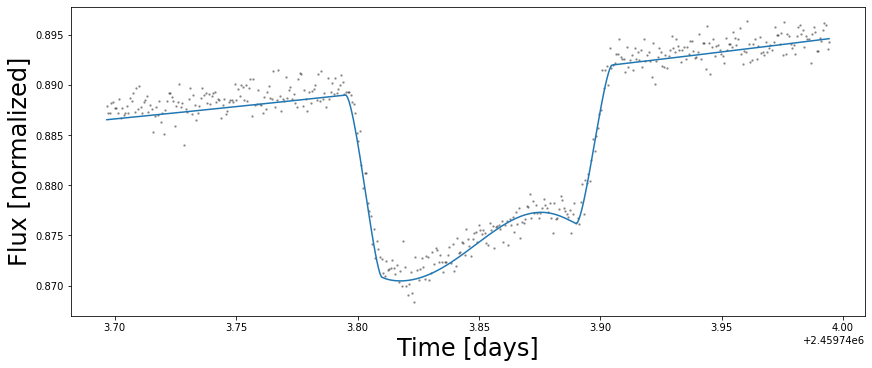

In [140]:
plt.figure(figsize=(12, 5))
plt.plot(s.data.time.to_value('d'), s.data.flux[0], "k.", alpha=0.3, ms=3)
plt.plot(s.data.time.to_value('d'), map_soln["flux_model"])
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

In [141]:
import pymc3_ext

with mod:
    trace = pm.sample(
        tune=100,
        draws=100,
        start=map_soln,
        chains=2,
        cores=2,
        target_accept=0.9,
    )

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
/var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/ipykernel_6872/2398637720.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(
Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: A

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 160 seconds.
INFO:pymc3:Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 160 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.o

In [142]:
with mod:
    summary = az.summary(trace)
    
summary

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lat,-0.004,0.007,-0.016,0.008,0.004,0.004,3.0,16.0,2.22
lon,0.028,0.013,0.004,0.050,0.008,0.007,3.0,16.0,2.01
A,1.008,0.000,1.008,1.009,0.000,0.000,5.0,71.0,1.30
contrast,0.768,0.001,0.767,0.770,0.000,0.000,4.0,23.0,1.57
spot_radius,27.056,0.027,27.007,27.099,0.015,0.011,4.0,28.0,1.59
...,...,...,...,...,...,...,...,...,...
flux_model[464],0.895,0.000,0.895,0.895,0.000,0.000,53.0,150.0,1.04
flux_model[465],0.895,0.000,0.895,0.895,0.000,0.000,53.0,150.0,1.04
flux_model[466],0.895,0.000,0.895,0.895,0.000,0.000,53.0,150.0,1.04
flux_model[467],0.895,0.000,0.895,0.895,0.000,0.000,53.0,150.0,1.04


In [109]:
with mod:
    summary = az.summary(trace)
    
summary

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lat,-0.115,0.130,-0.329,0.073,0.067,0.051,5.0,36.0,1.38
lon,-0.152,0.261,-0.561,0.196,0.170,0.139,3.0,13.0,2.44
A,1.000,0.003,0.996,1.005,0.000,0.000,90.0,65.0,1.04
contrast,0.604,0.022,0.563,0.639,0.011,0.008,5.0,56.0,1.38
spot_radius,29.894,0.695,28.671,31.138,0.269,0.199,7.0,54.0,1.23
...,...,...,...,...,...,...,...,...,...
flux_model[464],0.895,0.000,0.895,0.895,0.000,0.000,313.0,185.0,1.00
flux_model[465],0.895,0.000,0.895,0.895,0.000,0.000,314.0,185.0,1.00
flux_model[466],0.895,0.000,0.895,0.895,0.000,0.000,314.0,185.0,1.00
flux_model[467],0.895,0.000,0.895,0.895,0.000,0.000,315.0,185.0,1.00


In [183]:
# contrast=0.6, radius=30, lat=0, lon=0

In [143]:
with pm.Model() as model:

    # Primary
    recovered = starry.Primary(
        starry.Map(ydeg=hatp18_params["ydeg"], udeg=hatp18_params["udeg"], amp=hatp18_params["amp"]),
        r=hatp18_params["r"],
        m=hatp18_params["m"],
        prot=hatp18_params["prot"],
        length_unit=u.R_sun,
        mass_unit=u.M_sun,
    )
#     recovered.map[1:] = [summary['mean']['ld[0]'],summary['mean']['ld[1]']]
    recovered.map[1:] = hatp18_params["u"]
    
    recovered.map.spot(contrast=summary['mean']['contrast'], 
                       radius=summary['mean']['spot_radius'], 
                       lat=summary['mean']['lat'], 
                       lon=summary['mean']['lon'])
    
#     planet = starry.kepler.Secondary(
#         starry.Map(ydeg=5, amp=5e-3),  # the surface map
#         m=62.610,  # mass in solar masses
#         r=summary['mean']['radius'],  # radius in solar radii
#         porb=5.508023,  # orbital period in days
#         prot=5.508023,  # rotation period in days (synchronous)
#         inc=hatp18_params["inc"],
#     #     Omega=120,  # longitude of ascending node in degrees
#         ecc=summary['mean']['ecc'],  # eccentricity
#         omega=summary['mean']['omega'],  # longitude of pericenter in degrees
#         t0=summary['mean']['transit_epoch'],  # time of transit in days
#         length_unit=u.R_earth,
#         mass_unit=u.M_earth,
#         )

    planet = starry.kepler.Secondary(
        starry.Map(ydeg=5, amp=5e-3),  # the surface map
        m=62.610,  # mass in solar masses
        r=11.153,# radius
        inc=hatp18_params["inc"],
        length_unit=u.R_earth,
        mass_unit=u.M_earth,
        porb=5.508023,  # orbital period in days
        prot=5.508023,  # rotation period in days (synchronous)
        omega=120,  # longitude of ascending node in degrees
        ecc=0.084,  # eccentricity
        t0=2459743.85,  # time of transit in days
        )
    
    sys_recovered = starry.System(recovered, planet)
    
    # Our model for the flux
#     print(eval_in_model(pri.map.flux(theta=360*t/A["prot"])))
#     flux_model = pm.Deterministic("flux_model", sys.flux(t))

In [111]:
recovered.map.show(theta=np.linspace(0, 360, 50))

In [152]:
sys_recovered.show(t)

In [151]:
star_theory.map.show(theta=np.linspace(0, 360, 50))

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0


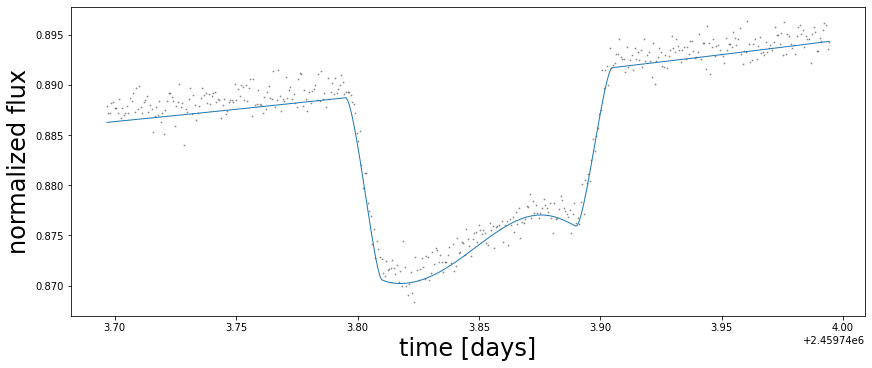

In [145]:
flux_recovered = eval_in_model(summary['mean']['A']*sys_recovered.flux(t), model=model)
# flux_recovered = flux_recovered/np.nanmedian(flux_recovered)
# flux_true = eval_in_model(star.map.flux(theta=360*bin_hatp18b.time.to_value('d')/A["prot"]), model=model)
# sigma = 0.0001
# flux = flux_true + sigma * np.random.randn(len(t))
# ferr = sigma * np.random.randn(len(t))

fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(t, flux, "k.", alpha=0.3, ms=2)
# plt.errorbar(t, flux, ferr, c="k", alpha=0.3)
ax.plot(t, flux_recovered, lw=1)
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24);

In [186]:
summary['mean']#['A']

lat                 1.476
lon                 1.272
A                   0.994
contrast            0.675
spot_radius        27.578
                    ...  
flux_model[464]     0.895
flux_model[465]     0.895
flux_model[466]     0.895
flux_model[467]     0.895
flux_model[468]     0.895
Name: mean, Length: 474, dtype: float64

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0


Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/corner/core.py:103: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(


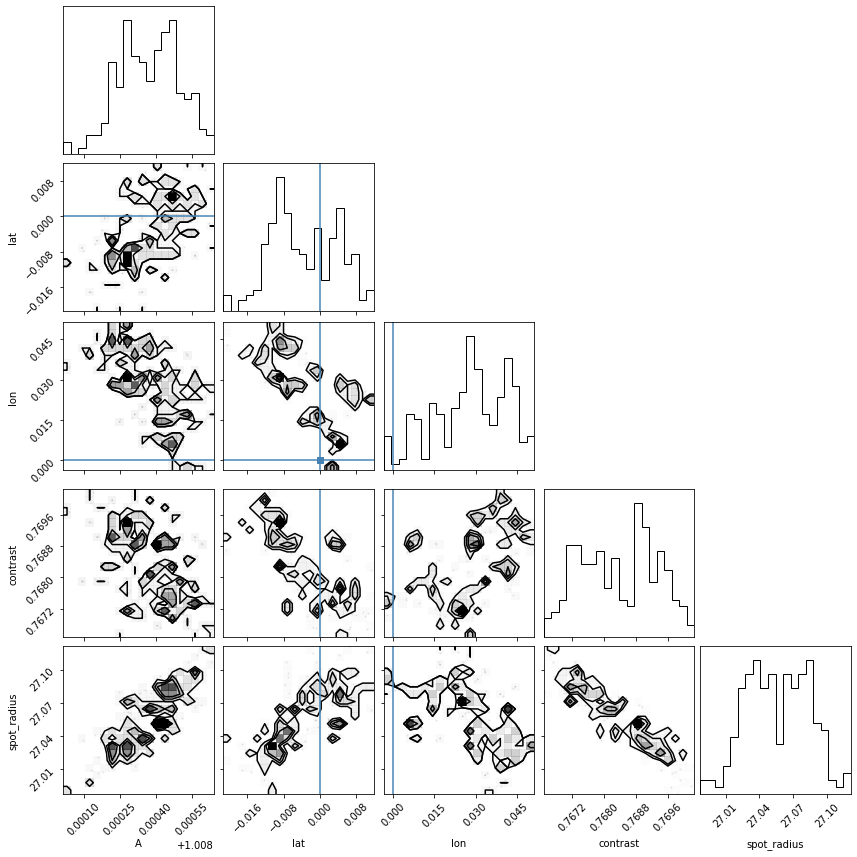

In [146]:
with mod:
    corner.corner(trace,var_names=['A','lat','lon','contrast','spot_radius'], truths=[1,0,0,0.6, 30])

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncS

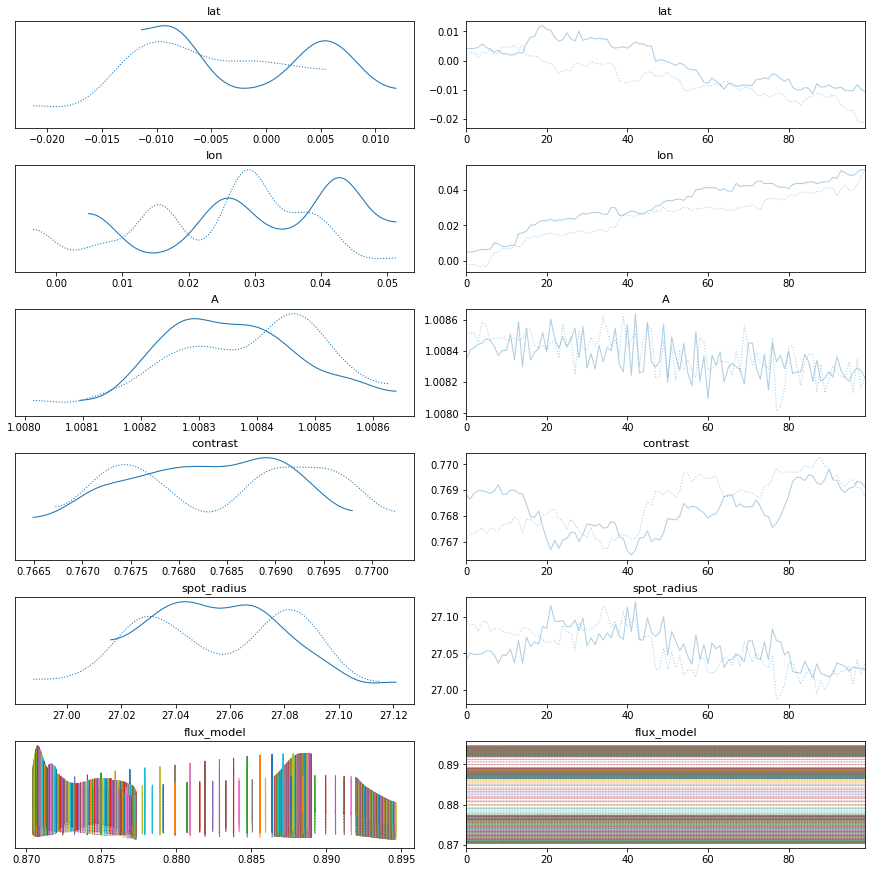

In [147]:
with mod:
    az.plot_trace(trace)

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncS

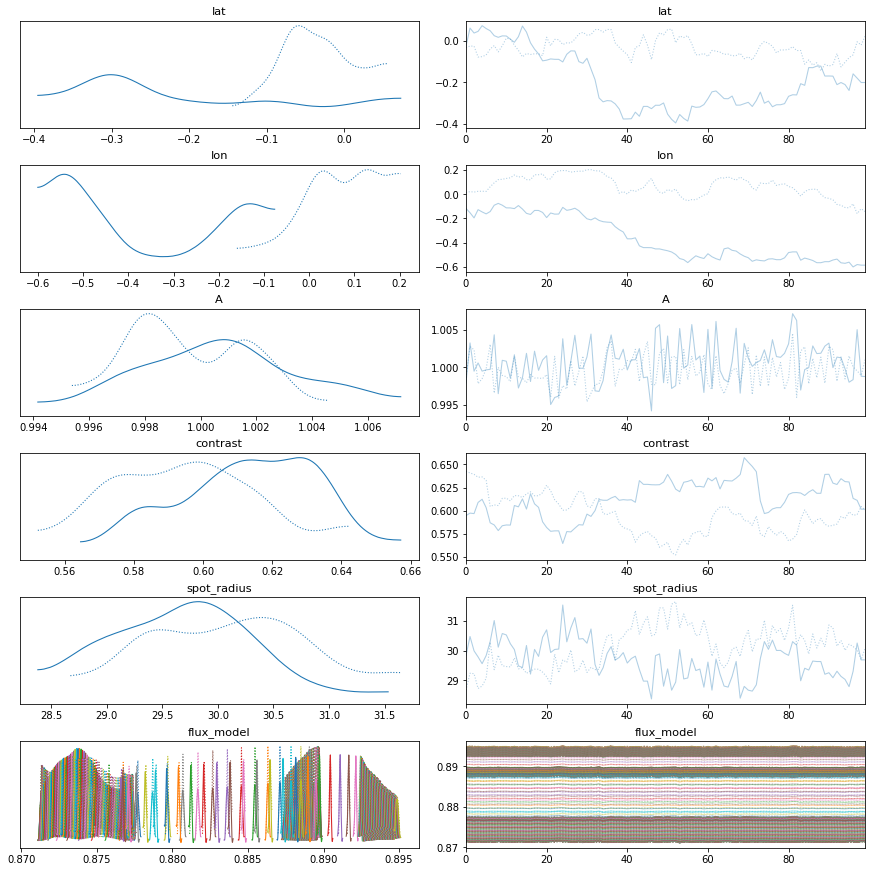

In [116]:
with mod:
    az.plot_trace(trace)